In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 对单元格的字符进行分割

In [2]:
file_path = '../sheet_src_imgs/1-17-2.jpg'
image = cv2.imread(file_path)
thresh = 0.15

1. 对输入图片灰度化后进行均值滤波，达到模糊的效果  
2. 由于字符的颜色比背景要深，所以需要对图片进行灰度值反转

Text(0.5, 1.0, 'inverse image')

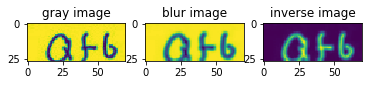

In [3]:
if not image.ndim == 3:
    raise ValueError

height, width = image.shape[:2]
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
mean_kernel = np.ones((3, 3), np.uint8) / 9
blur_img = cv2.filter2D(gray_img, -1, mean_kernel)
inv_img = ~blur_img

fig, axes = plt.subplots(1, 3)
axes[0].imshow(gray_img)
axes[1].imshow(blur_img)
axes[2].imshow(inv_img)
axes[0].set_title("gray image")
axes[1].set_title("blur image")
axes[2].set_title("inverse image")

3. 通过对灰度值反转后的图片进行自适应阈值处理，得到字符高亮显示的二值图，当然在这时的图片中会包含较多噪声点
4. 首先通过设定的阈值对二值图进行有无字符的预判，如果二值图的像素均值小于给定阈值，则认为该图片中不存在字符
5. 对于预判之后存在字符的图片，通过找边缘的方式来过滤掉噪声（噪声一般来说尺寸较小，通过cv2.findContours()找到轮廓后，通过cv2.contourArea(contour)可以得到轮廓所包含的面积，对于面积较小的轮廓，认为其为噪声，而不是字符，需要删去）

0.3634920634920635


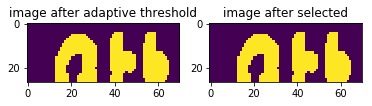

In [4]:
binary_img = cv2.adaptiveThreshold(inv_img, 1, cv2.ADAPTIVE_THRESH_MEAN_C, 
    cv2.THRESH_BINARY, 19, -2)
kernel_dilate = np.ones((int(height/4), 1), np.uint8)
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_DILATE, kernel_dilate)

# if np.mean(binary_img) <= thresh:
print(np.mean(binary_img))

if np.mean(binary_img) > thresh:
    _, contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    selected_contours = []
    for contour in contours:
        if cv2.contourArea(contour) < width * height / 50:
            continue
        selected_contours.append(contour)
        contours_img = np.zeros_like(binary_img)
        cv2.drawContours(contours_img, selected_contours, -1, 1, -1)

    kernel_open = np.ones((3, 1), np.uint8)
    contours_img = cv2.morphologyEx(contours_img, cv2.MORPH_OPEN, kernel_open)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(binary_img)
    axes[0].set_title("image after adaptive threshold")
    axes[1].imshow(contours_img)
    axes[1].set_title("image after selected")

通过观察上面经过轮廓筛选之后的图可以发现，字符的上下和左右部分会有留白的区域，对于这部分区域需要进行裁剪，从而可以得到较为精确的字符分割区域  
6. 统计图像横向和纵向的像素个数分布情况，因为每个像素的像素值都设置为1，所以直接求和得到的就是像素个数

Text(0.5, 1.0, 'col count')

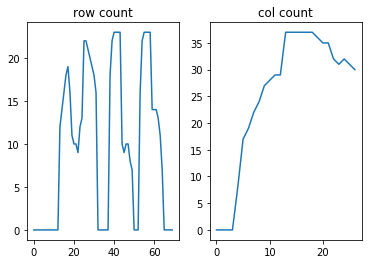

In [5]:
row_count = np.sum(contours_img, axis = 0)
col_count = np.sum(contours_img, axis = 1)
fig, axes = plt.subplots(1, 2)
axes[0].plot(row_count)
axes[0].set_title("row count")
axes[1].plot(col_count)
axes[1].set_title("col count")

7. 根据横向统计信息和纵向统计信息，分别将左右两侧和上下两侧的留白区域裁剪掉。这一步如果进行了裁剪，需要更新原图image，二值图 contours_img，以及row_count和col_count两个数组

23 56


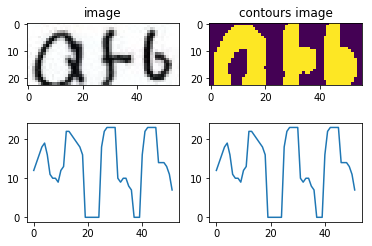

In [6]:
col_begin = width
col_end = 0
for i in range(width):
    if row_count[i] >= 2:
        col_begin = i
        for j in range(width):
            if row_count[width - 1 - j] >= 2:
                col_end = width - j
                break
        break

row_begin = height
row_end = 0
for i in range(height):
    if col_count[i] >= 2:
        row_begin = i
        for j in range(height):
            if col_count[height - 1 - j] >= 2:
                row_end = height - j
                break
        break
    
if col_begin < col_end:
    image = image[max(0, row_begin): min(height, row_end), 
                  max(0, col_begin - 2): min(width, col_end + 2), :]
    contours_img = contours_img[max(0, row_begin): min(height, row_end), 
                                max(0, col_begin - 2): min(width, col_end + 2)]
    row_count = row_count[col_begin: col_end]
    col_count = col_count[row_begin: row_end]
    height, width = image.shape[:2]
print(height, width)
    
fig, axes = plt.subplots(2, 2)
axes[0][0].imshow(image)
axes[0][0].set_title("image")
axes[0][1].imshow(contours_img)
axes[0][1].set_title("contours image")
axes[1][0].plot(row_count)
axes[1][1].plot(row_count)

8. 从 row_count 中找到所有波峰和波谷的索引，分别保存在波峰数组和波谷数组中，需要包含索引值和波峰或波谷的数值信息

23
[0, 21, 38, 56]


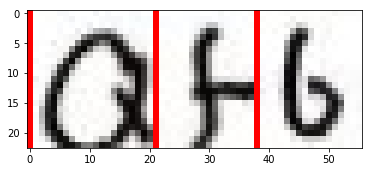

In [7]:
trough = [0]
max_peak = max(row_count)
print(max_peak)
for i in range(1, len(row_count)-1):
    # 当波谷是一条横线，找左分割边界
    if (row_count[i] <= row_count[i - 1] and row_count[i] < row_count[i + 1])\
        and row_count[i] < max_peak / 3:
        if len(trough) > 0 and (i - 1 - trough[-1]) <= 3:       # 保证分割的间距要大于3个像素
            trough[-1] = int((i - 1 + trough[-1]) / 2)
        else:
            trough.append(i - 1)
            
    # 当波谷是一条横线，找左分割边界
    if (row_count[i] < row_count[i - 1] and row_count[i] <= row_count[i + 1])\
        and row_count[i] < max_peak / 3:
        if len(trough) > 0 and (i + 1 - trough[-1]) <= 3:
            trough[-1] = int((i + 1 + trough[-1]) / 2)
        else:
            trough.append(i + 1)
trough.append(width)
for i in trough:
    cv2.line(image, (i, 0), (i, height), (0, 0, 255), 1)
    
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print(trough)

通过上述方法找出波谷之后可以对字符之间分隔较大的图片进行分割，但是有些字符是黏连在一起的，就无法进行分割了。  
9. 对分割的宽度进行筛选和调整：  
a. 分割宽度小于3个像素的，进行合并，用均值作为新的分割边界  
b. 最大的分割宽度如果大于第二大的分割宽度的1.5倍，对最大分割宽度进行均分  
c. 如没有找到波谷，按图片中点进行均分  
d. 如果总的分割字符数大于等于3，并且宽度前二小的字符相邻，并且之和小于第三小的字符的1.2倍，则将前二小的字符图片进行合并

width of every characters:  [(0, 21), (1, 17), (2, 18)]
sorted width of every characters:  [(1, 17), (2, 18), (0, 21)]


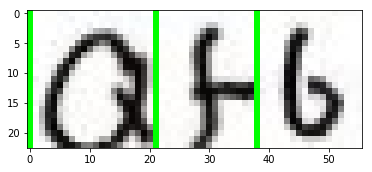

In [11]:
# 如果没有找到波谷，就进行均分
if len(trough) <= 2:
    trough.insert(1, int(width / 2))
    
# 如果最大的分割宽度大于第二大分割宽度的1.5倍，就对最大分割宽度进行均分
# 记录每个分割宽度的列表
split_width = []
for i in range(len(trough) - 1):
    split_width.append(trough[i + 1] - trough[i])
# split_width.append(width - trough[-1][0])
split_width = list(zip(range(len(split_width)), split_width))
print("width of every characters: ", split_width)
# 对split_width进行排序
split_width = sorted(split_width, key = lambda x: x[1])
print("sorted width of every characters: ", split_width)
if split_width[-1][1] > split_width[-2][1] * 1.5:
    trough.insert(split_width[-1][0] + 1, int(trough[split_width[-1][0]] + split_width[-1][1] / 2))
for i in trough:
    cv2.line(image, (i, 0), (i, height), (0, 255, 0), 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [9]:
# 按规则d进行合并
print(max(split_width[0][0], split_width[1][0]))
print(trough)
if len(split_width) >= 3:
    if abs(split_width[0][0] - split_width[1][0]) == 1:
        if split_width[0][1] + split_width[1][1] < 1.2 * split_width[2][1]:
            trough.remove(trough[max(split_width[0][0], split_width[1][0])])

2
[0, 21, 38, 56]


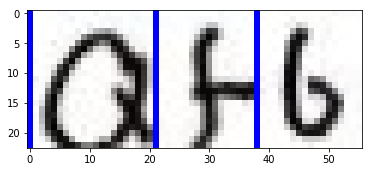

In [10]:
for i in trough:
    cv2.line(image, (i, 0), (i, height), (255, 0, 0), 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))